Method:
* Look at Andrea's summary for PDMPs, and more specifically the Zig Zag sampler.
* The process can be defined from ($\varphi, \lambda, Q$) where
    * $\varphi$ is the ODE dynamics - or the integral path defined by a vector field $\Phi$
    * $\lambda$ is the probability that a jumps occurs during the particle's movement
    * $Q$ is the Markov kernel used for the jump


For the reverse process, we essentially just need to compute, for all $i$:
$$ \bar \lambda_i = \lambda_i \dfrac{p_t(x_t, R_i v_t)}{p_t(x_t, v_t)} $$
We can either fit the model to

* $\bar \lambda$, and obtain the following loss:
    $$ \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - \lambda(x, v) s_{\theta}(x, R v, t)$$
* $\dfrac{p_t(x_t, R v_t)}{p_t(x_t, v_t)}$ and obtain the following loss:
    $$ \mathbb{E}_{t, x, v} \|  s_{\theta}(x, v, t) - \dfrac{p_t(x_t, R v_t)}{p_t(x_t, v_t)}\|^2 =  \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t)$$



make $s_{\theta}$ invariant to $Rv$.

ZigZag:
* $\Phi(x, v)$ = v
* $\lambda(x, v)_i = (v_i (\partial \psi(x))_i)_+$, with $\pi \propto \exp(-\psi(x))$ the target distribution. For Gaussian distribution:
$$\lambda(x, v)_i = (v_i x_i)_+ $$
* Q reverses speed.

Model:
* Model takes $(X_t, V_t)$ as input (4d)
* Outputs $\bar \lambda_i$ for each i
* Current limitations: if the dimension is $d$, we need $d+1$ forward pass, because:
$$ \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t) = \mathbb{E}_{t, x, v} \sum_{i=1}^d \frac12 s_{\theta}(x, v, t)_i^2 - s_{\theta}(x, R_i v, t)_i$$ 

**Remark** I have noticed that running the forward with small timesteps makes for slow/no convergence. How come?

# PDMP

## Setup

* Model takes $(X_t, V_t)$ as input (4 in 2d). Outputs $\lambda_i$ for each i (2 in 2d)
* Some of the code is relying on dictionnaries to define constituting parameters

In [1]:
import numpy as np
import torch
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True,
    'dropout_rate' : .1,
    'nblocks' : 2,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, 
    'compute_gamma': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'gmm_2',
    'std' : 0.1, # 0.5, 0.05,
    'n_mixture' : 2, # must be square. set to None if not a grid mixture
    'normalize' : True,
    #'weights': np.array([1/2]*2),
    'weights': None,#[.01, .1, .3, 
               # .2, .02, .15,
               # .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'alpha': 2.,
    #'isotropic': True
}

device = 'mps'

* Prepare all our objects

In [2]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import initial_code.pdmp as pdmp
import Data as Data
import Generate as Gen
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt

# original data, get dataloader
gmm_2 = Data.Generator(**p_data_2d)#('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate()
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset(GMM2)#, torch.tensor([0.]).repeat(GMM2.shape[0]))
data = DataLoader(dataset, 
                batch_size=p_data_2d['nsamples'] // 4, 
                shuffle=True, 
                num_workers=1)

# model
model = LevyDiffusionModel({'data': {'nfeatures': p_data_2d['nfeatures']}, 'model':p_model_2d, 'device': 'cpu'}).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=1e-2, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = pdmp.PDMP(total_time = 30)

# Manager for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

## Look at the noised data

In [16]:
# clone data, since it will be modified by forward process
data_clone = GMM2.clone()
# orint its shape
print(data_clone.shape)
# get a unit time horizon
time_horizons = torch.ones(data_clone.shape) * pdmp.T
# forward process for pmdp.T time units
pdmp.forward(data_clone, time_horizons)

torch.Size([32768, 1, 2])


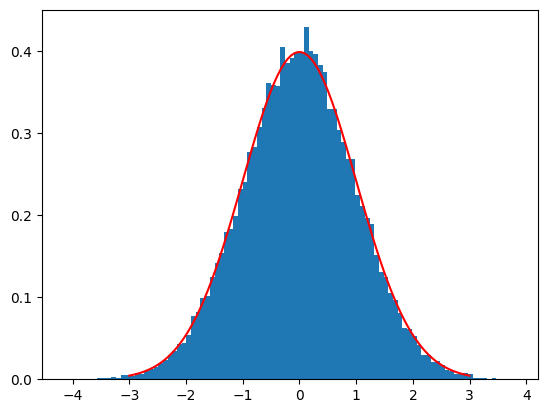

In [17]:
# look at histogram of one component at the last timestep

pos = data_clone.squeeze(1) # remove channel dimension
import scipy.stats as stats
X = np.linspace(-3, 3, 100)
Y = stats.norm.pdf(X, 0, 1)
plt.plot(X, Y, color='red')
plt.hist(pos[:, 0], bins='auto', density=True)
plt.show()

## Train the model

In [3]:
# can use this to load a model and optimizer

MODEL_PATH = 'models/first_model.pt'

chpt = torch.load(MODEL_PATH)
model.load_state_dict(chpt['model'])
optimizer.load_state_dict(chpt['optimizer'])

In [5]:
# actually training the model

from tqdm import tqdm
import torch.nn as nn

# potential gradient clipping
grad_clip = None

# training
model.train()
for i in tqdm(range(5)):
    epoch_loss = steps = 0
    for i, (Xbatch,) in enumerate(data):
        # training loss

        # generate random speed
        Vbatch = torch.tensor([-1., 1.])[torch.randint(0, 2, (2*Xbatch.shape[0],))]
        Vbatch = Vbatch.reshape(Xbatch.shape[0], 1, 2)

        # generate random time horizons
        time_horizons = pdmp.T * torch.rand(Xbatch.shape[0])
        # must be of the same shape as Xbatch for the pdmp forward process, since it will be applied component wise
        t = time_horizons.clone().detach().unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 2)
        
        # clone our initial data, since it will be modified by forward process
        x = Xbatch.clone()
        v = Vbatch.clone()
        
        # apply the forward process
        pdmp.forward(Xbatch, t, Vbatch)
        
        # check that the data has been modified
        assert ((x != Xbatch).any()) and ((v != Vbatch).any())
        # check that the time horizon has been reached for all data
        assert not (t != 0.).any()
        
        # send to device
        Xbatch = Xbatch.to(device)
        Vbatch = Vbatch.to(device)
        time_horizons = time_horizons.to(device)
        
        # tensor to give as input to the model. It is the concatenation of the position and the speed.
        X_V_t = torch.concat((Xbatch, Vbatch), dim = -1)

        # run the model
        output = model(X_V_t, time_horizons)
        
        # invert time on component 1 and 2
        X_V_inv_t_1 = X_V_t.detach().clone() # clone to avoid modifying the original tensor, detach to avoid computing gradients on original tensor
        X_V_inv_t_2 = X_V_t.detach().clone()
        X_V_inv_t_1[:, :, 2] *= -1 # reverse speed on i = 1
        X_V_inv_t_2[:, :, 3] *= -1 # reverse speed on i = 2

        # run the model on each inverted speed component
        output_inv_1 = model(X_V_inv_t_1, time_horizons)
        output_inv_2 = model(X_V_inv_t_2, time_horizons)
        
        # compute the loss
        loss = 0.5*output[:, :, 0]**2 - (output_inv_1[:,:,0])
        loss += 0.5*output[:, :, 1]**2 - (output_inv_2[:,:,1])

        loss = loss.mean()
        # and finally gradient descent
        optimizer.zero_grad()
        loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        # add to epoch loss
        epoch_loss += loss.item()
        steps+= 1
    # compute epoch loss
    epoch_loss = epoch_loss / steps
    print('epoch_loss :{}'.format(epoch_loss))

  0%|                                                                                                                                      | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████▏                                                                                                    | 1/5 [00:03<00:13,  3.38s/it]

epoch_loss :0.5374230593442917


 40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:05<00:07,  2.46s/it]

epoch_loss :-0.5564105212688446


 60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:06<00:04,  2.13s/it]

epoch_loss :-0.8612456321716309


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [00:08<00:02,  2.01s/it]

epoch_loss :-0.9531546533107758


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.07s/it]

epoch_loss :-0.9383057206869125


In [6]:
# save the model
MODEL_PATH = 'models/first_model.pt'

checkpoint = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(checkpoint, MODEL_PATH)

# Reverse Sampling

## Reverse process

In [4]:
# generate data
## For the backward process
def flip_given_rate(v, lambdas, s):
    lambdas[lambdas == 0.] += 1e-9
    event_time = torch.distributions.exponential.Exponential(lambdas)
    v[event_time.sample() <= s] *= -1.

def splitting_zzs_DBD(model, δ, N, nsamples = None, x_init=None, v_init=None):
    assert (nsamples is not None) or (x_init is not None) or (v_init is not None) 
    if x_init is None:
        x_init = torch.randn(nsamples, 1, 2)
    if v_init is None:
        v_init = torch.tensor([-1., 1.])[torch.randint(0, 2, (x_init.shape[0],))].reshape(x_init.shape[0], 1, 1).repeat(1, *(x_init.shape[1:]))
    #chain = [pdmp.Skeleton(torch.clone(x_init), torch.clone(v_init), 0.)]
    chain = []
    x = x_init.clone()
    v = v_init.clone()
    model.eval()
    #print(x)
    with torch.inference_mode():
        for n in range(int(N), 1, -1):
            chain.append(torch.concat((x, v), dim = -1))
            # compute x_n-1 from x_n
            x = x - v * δ / 2
            time = float(n * δ - δ / 2) #float(n - δ / 2)
            density_ratio = model(torch.concat((x,v), dim = -1).to(device),
                                  (torch.ones(x.shape[0])*time).to(device))
            #print(density_ratio)
            #print(grad_x)
            switch_rate = density_ratio.cpu()* torch.maximum(torch.zeros(x.shape), -v * x)
            #print(switch_rate)
            #print(switch_rate[switch_rate <= 0.])
            flip_given_rate(v, switch_rate, δ)
            x = x - v * δ / 2
            #print(x, v)
            #chain.append(Skeleton(x.copy(), v.copy(), n * δ))
    chain.append(torch.concat((x, v), dim = -1))
    return chain


## Generate data

In [5]:
# generate the reverse chain
delta = 1e-1
chain = torch.stack(splitting_zzs_DBD(model, delta, pdmp.T / delta, nsamples = 100))

## Inspect generated data trajectory - from noise to data distribution

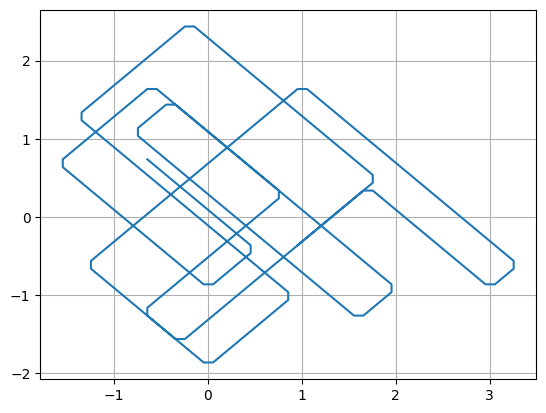

In [6]:
# Look at the position of the particle through time
pos = chain[:, 0, :, :2].squeeze(-2) # squeeze: remove channel dimension
plt.plot(pos[:, 0], pos[:, 1], linestyle='-')
plt.grid(True)
plt.show()

We can now use our GenerationManager object to examine the generated data.

* get animation

'./animation/check.mp4'

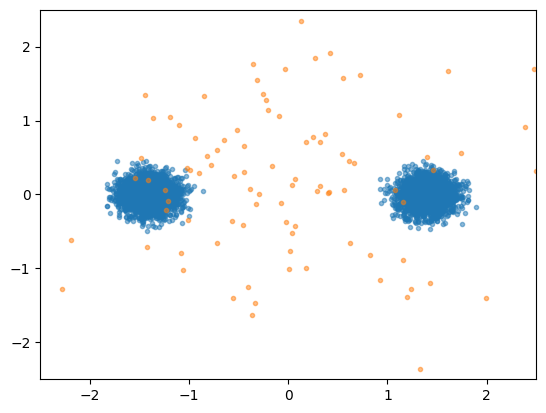

In [7]:
# Use Generation manager object to generate animation from the history of the data
gen_model.history = chain[:, :, :, :2]
gen_model.animation(generated_data_name = 'check')

* Get plot of the generated data.

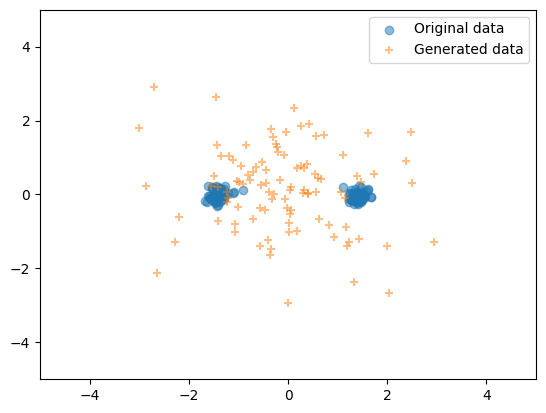

In [10]:
lims = 5
gen_model.samples = chain[-1, :, :, :2].squeeze(-2) # get the last position of every sample, remove channel dimension
gen_model.get_plot(limit_nb_orig_data = 100, # number of original data to plot
                   xlim = (-lims, lims), ylim = (-lims, lims))